# RL and Advanced DL: Домашнее задание 1

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.


# Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек. 

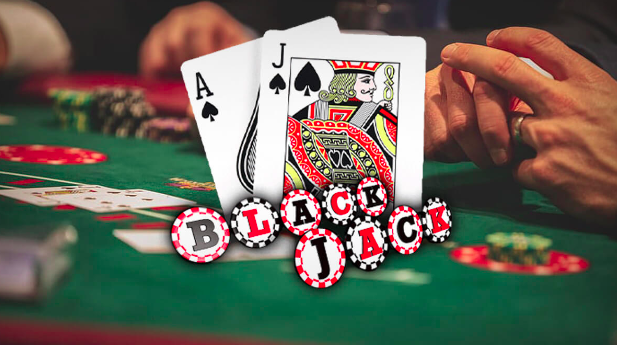

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть **usable ace**), и за 1 очко, если превосходит;
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
- игрок может совершать одно из двух действий:
  + **hit**  — взять ещё одну карту;
  + **stand** — не брать больше карт;
- если сумма очков у игрока на руках больше 21, он проигрывает (**bust)**;
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
- в исходных правилах есть ещё дополнительный бонус за **natural blackjack**: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).


Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.


In [ ]:
from collections import defaultdict
import gym
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
env = gym.make('Blackjack-v1')
env.reset();

In [ ]:
STATES = [*itertools.product(
    range(4, 22), # сумма очков у игрока на руках
    range(1, 11), # значения открытой карты дилера 
    (True, False) # usable_ace
)]

# 0 - stand, 1 - hit
simple_policy = {state: int(state[0] < 19) for state in STATES}

In [ ]:
def run_episode(policy, env=env, eps=0):
    state = env.reset()

    states, actions, rewards, done = [], [], [], False

    while not done:
        states.append(state)

        action = policy[state] if random.random() > eps else env.action_space.sample()
        actions.append(action)

        state, reward, done, _ = env.step(action)
        rewards.append(reward)

    return states, actions, rewards

In [ ]:
def evaluate_policy(policy, env=env, total_episodes=100_000):
    R = 0
    for _ in range(total_episodes):
        _, _, r = run_episode(policy=policy, env=env)
        R += r[-1]
    return R / total_episodes

In [ ]:
evaluate_policy(policy=simple_policy)

-0.19642

Стратегия довольно проигрышная, игрок на 20% чаще проигрывает, чем выигрывает

2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.


In [ ]:
def Q_learning(env=env, eps=0.1, gamma=0.9, alpha=0.05, total_episodes=1_000_000):
    policy = defaultdict(int)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    state_action_visit_count = defaultdict(int)
    reward_array = []

    for _ in range(total_episodes):
        states, actions, rewards = run_episode(env=env, policy=policy, eps=eps)
        n = len(states)
        reward_array.append(rewards[-1])
        
        s_n, a_n, r_n = states[-1], actions[-1], rewards[-1]
        Q[s_n][a_n] = Q[s_n][a_n] + alpha * (r_n - gamma * np.max(Q[s_n]))

        for t in range(n - 1):
            s_t, a_t, r_t_1, s_t_1 = states[t], actions[t], rewards[t], states[t+1]  
            Q[s_t][a_t] = Q[s_t][a_t] + alpha * (r_t_1 + gamma * np.max(Q[s_t_1]) - Q[s_t][a_t])

            policy[s_t] = np.argmax(Q[s_t])

    return policy, reward_array

In [ ]:
def MC_control_on_policy(env=env, eps=0.1, gamma=0.9, total_episodes=1_000_000):
    policy = defaultdict(int)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    state_action_visit_count = defaultdict(int)
    reward_array = []

    for _ in range(total_episodes):
        states, actions, rewards = run_episode(env=env, policy=policy, eps=eps)
        n = len(states)
        reward_array.append(rewards[-1])
        s_a_pairs = [*zip(states, actions)]
        
        G = 0
        for t in range(n - 1, -1, -1):
            s_t, a_t, r_t = states[t], actions[t], rewards[t]

            G = r_t + gamma * G 
            if (s_t, a_t) in s_a_pairs[:t]:
                continue

            state_action_visit_count[(s_t, a_t)] += 1            
            alpha = 1 / state_action_visit_count[(s_t, a_t)]
            Q[s_t][a_t] = Q[s_t][a_t] + alpha * (G - Q[s_t][a_t])

            policy[s_t] = np.argmax(Q[s_t])

    return policy, reward_array

In [ ]:
def SARSA(env=env, eps=0.1, gamma=0.9, alpha=0.05, total_episodes=1_000_000):
    policy = defaultdict(int)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    state_action_visit_count = defaultdict(int)
    reward_array = []

    for _ in range(total_episodes):
        states, actions, rewards = run_episode(env=env, policy=policy, eps=eps)
        n = len(states)
        reward_array.append(rewards[-1])
        
        s_n, a_n, r_n = states[-1], actions[-1], rewards[-1]
        Q[s_n][a_n] = Q[s_n][a_n] + alpha * (r_n - gamma * Q[s_n][a_n])

        for t in range(n - 1):
            s_t, a_t, r_t_1, s_t_1, a_t_1 = states[t], actions[t], rewards[t], states[t+1], actions[t+1]  
            Q[s_t][a_t] = Q[s_t][a_t] + alpha * (r_t_1 + gamma * Q[s_t_1][a_t_1] - Q[s_t][a_t])

            policy[s_t] = np.argmax(Q[s_t])

    return policy, reward_array

In [ ]:
q_learning_policy, _ = Q_learning(env)
mc_control_policy, _ = MC_control_on_policy(env)
sarsa_policy, _ = SARSA(env)

print(f'Q-learning: {evaluate_policy(env=env, policy=q_learning_policy)}')
print(f'Monte-Carlo: {evaluate_policy(env=env, policy=mc_control_policy)}')
print(f'SARSA: {evaluate_policy(env=env, policy=sarsa_policy)}')

Q-learning: -0.04698
Monte-Carlo: -0.04182
SARSA: -0.05722


Все три стратегии оказались лучше стратегии из первого пункта, но они всё равно остались проигрышными

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [ ]:
def cumulative_mean(rewards_array, step=50_000):
    res = []
    n = len(rewards_array)
    for i in range(1, n // step + 1):
        res.append(sum(rewards_array[:step * i]) / step / i)
    return res

def dict_to_str(**kwargs):
    return ', '.join([f'{k}={v}' for k, v in kwargs.items()])

In [ ]:
def plot_mean_rewards(env, method, method_name, params, total_episodes=1_000_000):
    plt.figure(figsize=(12, 12))

    for kwargs in params:
        _, reward_array = method(env=env, total_episodes=total_episodes, **kwargs)
        plt.plot(cumulative_mean(reward_array), label=dict_to_str(**kwargs))

    plt.title(method_name)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
params_for_q_learning_n_sarsa = [
    {'eps': eps, 'alpha': alpha, 'gamma': gamma}
    for (eps, gamma, alpha) in itertools.product(
        (0, 0.1, 0.2),
        (0.1, 0.5, 1),
        (0.01, 0.05, 0.1)
    )]

params_for_mc = [
    {'eps': eps, 'gamma': gamma}
    for (eps, gamma) in itertools.product(
        (0, 0.1, 0.2),
        (0.1, 0.5, 1)
    )]

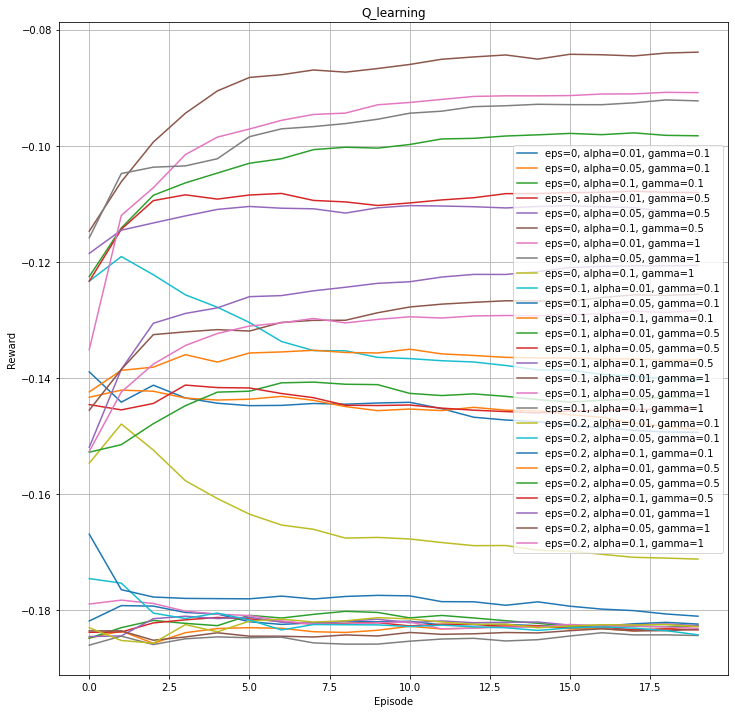

In [ ]:
plot_mean_rewards(
    env,
    Q_learning,
    'Q_learning',
    params_for_q_learning_n_sarsa
)

Для Q-learning лучшие параметры $\varepsilon = 0, \alpha = 0.1, \gamma = 0.5$

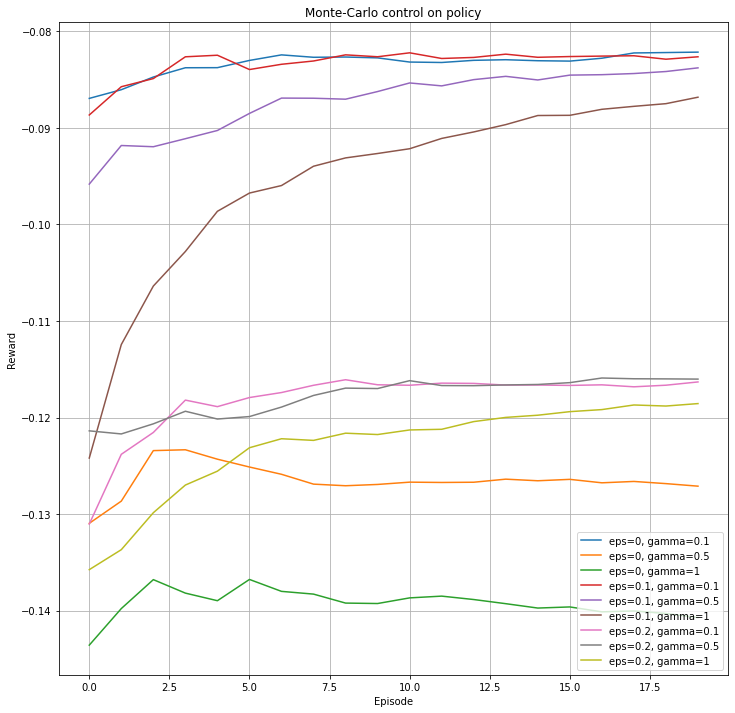

In [ ]:
plot_mean_rewards(
    env,
    MC_control_on_policy,
    'Monte-Carlo control on policy',
    params_for_mc
)

Для Monte-Carlo control on-policy лучшие параметры $\varepsilon = 0.1, \gamma = 0.1$

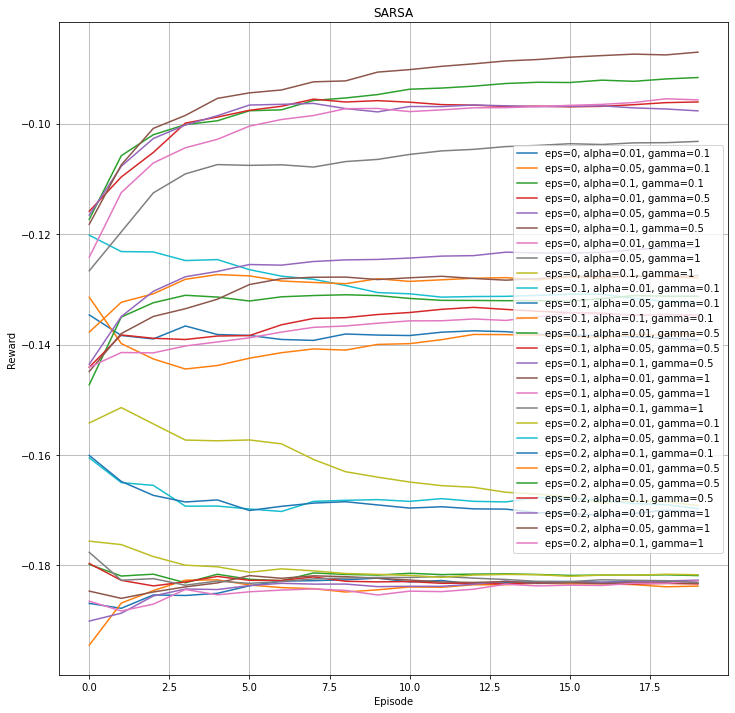

In [ ]:
plot_mean_rewards(
    env,
    SARSA,
    'SARSA',
    params_for_q_learning_n_sarsa
)

Для SARSA лучшие параметры $\varepsilon = 0, \alpha = 0.1, \gamma = 0.5$

Среди всех моделей лучше всего себя показала Monte-Carlo. Также если сравнивать значения с графиков со значениями, полученными со стандратными параметрами, то стандартные параметры показали себя лучше (видимо отлично их угадал :))

# Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

- **double** — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.


4. Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.

In [ ]:
from gym import spaces

def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class DoubleBlackjackEnv(gym.Env):

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        elif action == 0:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        else: # double
            terminated = True
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                reward = -2.0
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))

        return self._get_obs(), reward, terminated, False

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)

        return self._get_obs()

5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [ ]:
env = DoubleBlackjackEnv(natural=True)
env.reset();

In [ ]:
q_learning_policy, _ = Q_learning(env)
mc_control_policy, _ = MC_control_on_policy(env)
sarsa_policy, _ = SARSA(env)

print(f'Q-learning: {evaluate_policy(env=env, policy=q_learning_policy)}')
print(f'Monte-Carlo: {evaluate_policy(env=env, policy=mc_control_policy)}')
print(f'SARSA: {evaluate_policy(env=env, policy=sarsa_policy)}')

Q-learning: -0.03186
Monte-Carlo: -0.01168
SARSA: -0.03657


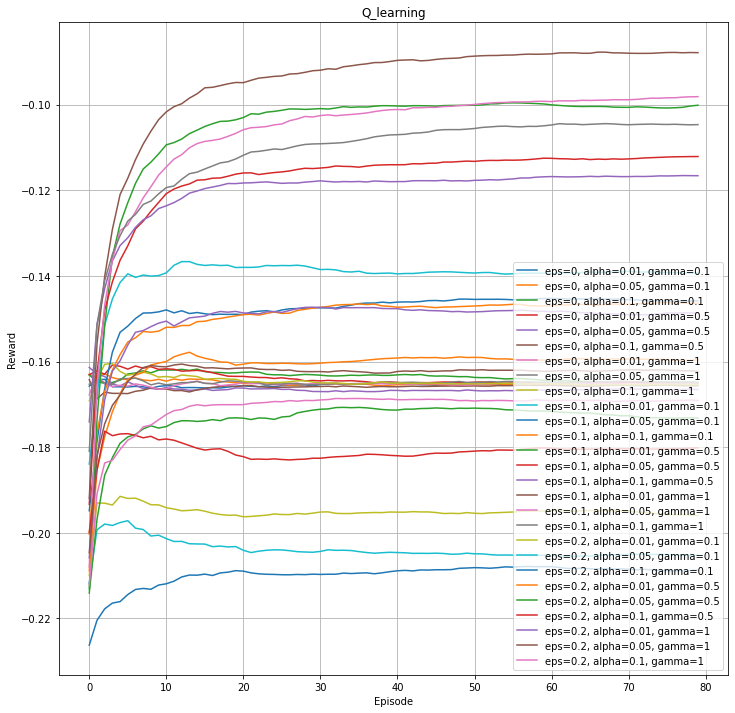

In [ ]:
plot_mean_rewards(
    env,
    Q_learning,
    'Q_learning',
    params_for_q_learning_n_sarsa,
    total_episodes=4_000_000
)

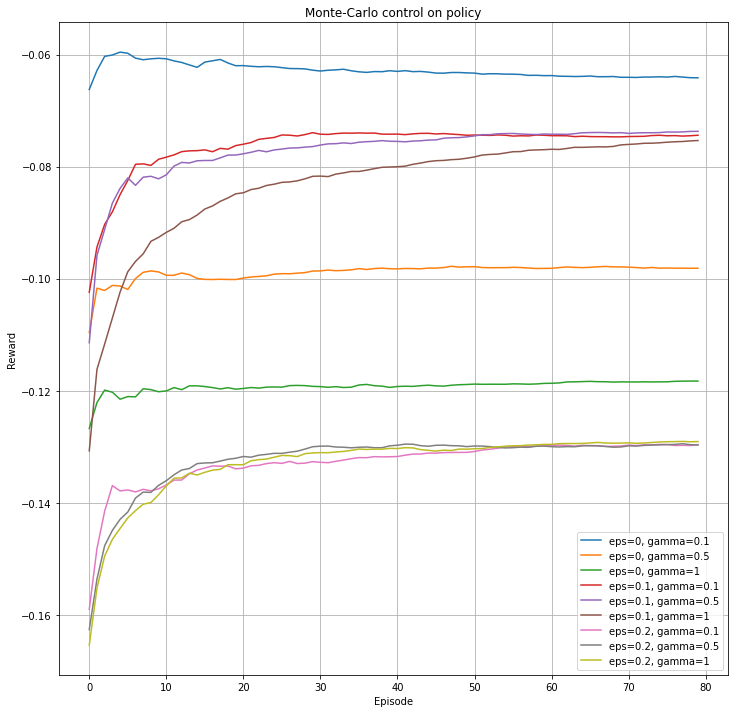

In [ ]:
plot_mean_rewards(
    env,
    MC_control_on_policy,
    'Monte-Carlo control on policy',
    params_for_mc,
    total_episodes=4_000_000
)

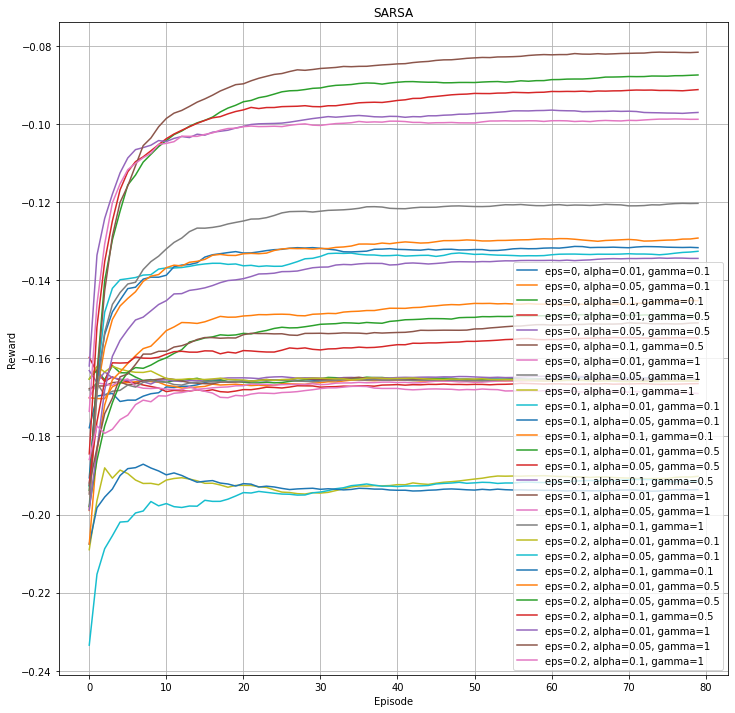

In [ ]:
plot_mean_rewards(
    env,
    SARSA,
    'SARSA',
    params_for_q_learning_n_sarsa,
    total_episodes=4_000_000
)

В среднем доход становится больше (вернее убытки становятся меньше)

# Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Думаю, у вас уже возникла в голове эта картинка:

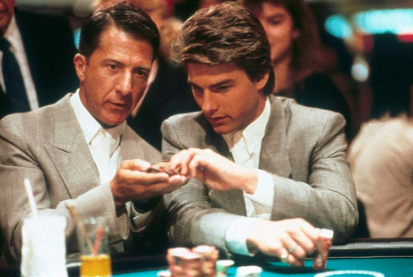


Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.


6. Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет [статья википедии о блекджеке](https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA) (а возможно, и нет).


In [ ]:
def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

# for strategy from wikipedia
halves = {
    1: -1,
    2: 0.5,
    3: 1,
    4: 1,
    5: 1.5,
    6: 1,
    7: 0.5,
    8: 0,
    9: -0.5,
    10: -1,
}

def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class CountingDoubleBlackjackEnv(gym.Env):

    def __init__(self, num_decks=6, reshuffle_on=15, natural=False, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2),
             spaces.Box(-22.0, 22.0, shape=(1, 1), dtype=np.float32))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        self.num_decks = num_decks

        self.reshuffle_on = reshuffle_on

        self.count = 0
        self.decks = deck * 4 * self.num_decks
        self.terminated = False
        self.player = []
        self.dealer = []

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def draw_card(self, np_random):
        if len(self.decks) < self.reshuffle_on:
            self.decks = deck * 4 * self.num_decks
            self.count = 0
            
            for card in self.player:
                self.decks.pop(self.decks.index(card))
                self.count += halves[card]

            for card in self.dealer:
                self.decks.pop(self.decks.index(card))

            for card in self.dealer[:-1]:
                self.count += halves[card]

            if self.terminated:
                self.count += halves[self.dealer[-1]]
              
        card = self.decks.pop(np_random.randint(0, len(self.decks)))

        return card

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            player_card = self.draw_card(self.np_random)
            self.count += halves[player_card]
            self.player.append(player_card)
            if is_bust(self.player):
                self.terminated = True
                reward = -1.0
                self.count += halves[self.dealer[1]]
            else:
                self.terminated = False
                reward = 0.0
        elif action == 0:  # stick: play out the dealers hand, and score
            self.terminated = True
            self.count += halves[self.dealer[1]]
            while sum_hand(self.dealer) < 17:
                dealer_card = self.draw_card(self.np_random)
                self.count += halves[dealer_card]
                self.dealer.append(dealer_card)
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        else: # double
            self.terminated = True
            player_card = self.draw_card(self.np_random)
            self.count += halves[player_card]
            self.player.append(player_card)
            self.count += halves[self.dealer[1]]
            if is_bust(self.player):
                reward = -2.0
                self.count += halves[self.dealer[1]]
            else:
                while sum_hand(self.dealer) < 17:
                    dealer_card = self.draw_card(self.np_random)
                    self.count += halves[dealer_card]
                    self.dealer.append(dealer_card)
                reward = 2 * cmp(score(self.player), score(self.dealer))

        return self._get_obs(), reward, self.terminated, False

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player),
                self.count / math.ceil(len(self.decks) / 52))

    def reset(self):
        self.terminated = False
        if len(self.decks) < self.reshuffle_on:
            self.count = 0
            self.decks = deck * 4 * self.num_decks
        
        self.dealer = self.draw_hand(self.np_random)
        self.count += halves[self.dealer[0]]
        
        self.player = self.draw_hand(self.np_random)
        self.count += halves[self.player[0]]
        self.count += halves[self.player[1]]

        return self._get_obs()

7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [ ]:
env = CountingDoubleBlackjackEnv(natural=True)
env.reset();

In [ ]:
q_learning_policy, _ = Q_learning(env)
mc_control_policy, _ = MC_control_on_policy(env)
sarsa_policy, _ = SARSA(env)

print(f'Q-learning: {evaluate_policy(env=env, policy=q_learning_policy)}')
print(f'Monte-Carlo: {evaluate_policy(env=env, policy=mc_control_policy)}')
print(f'SARSA: {evaluate_policy(env=env, policy=sarsa_policy)}')

Q-learning: -0.18402
Monte-Carlo: -0.09807
SARSA: -0.183405


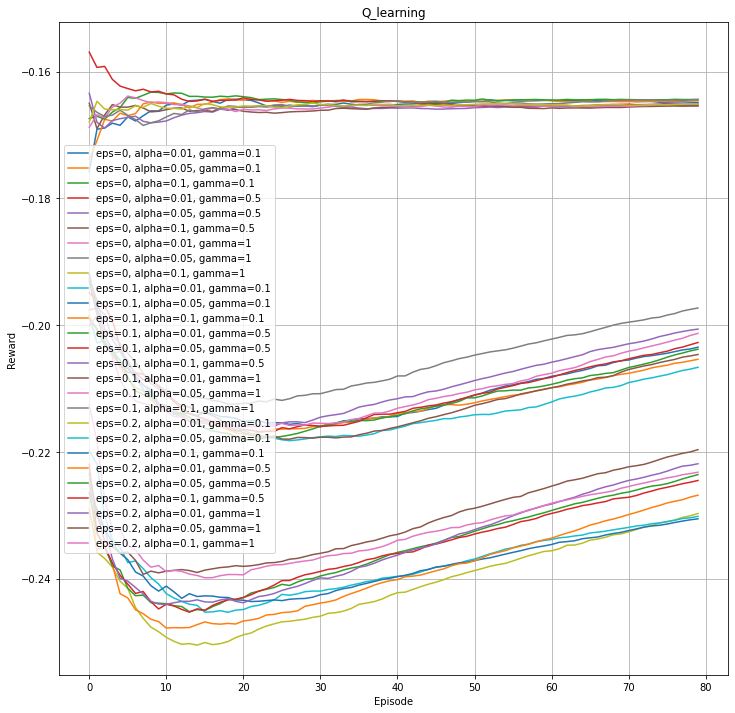

In [ ]:
plot_mean_rewards(
    env,
    Q_learning,
    'Q_learning',
    params_for_q_learning_n_sarsa,
    total_episodes=4_000_000
)

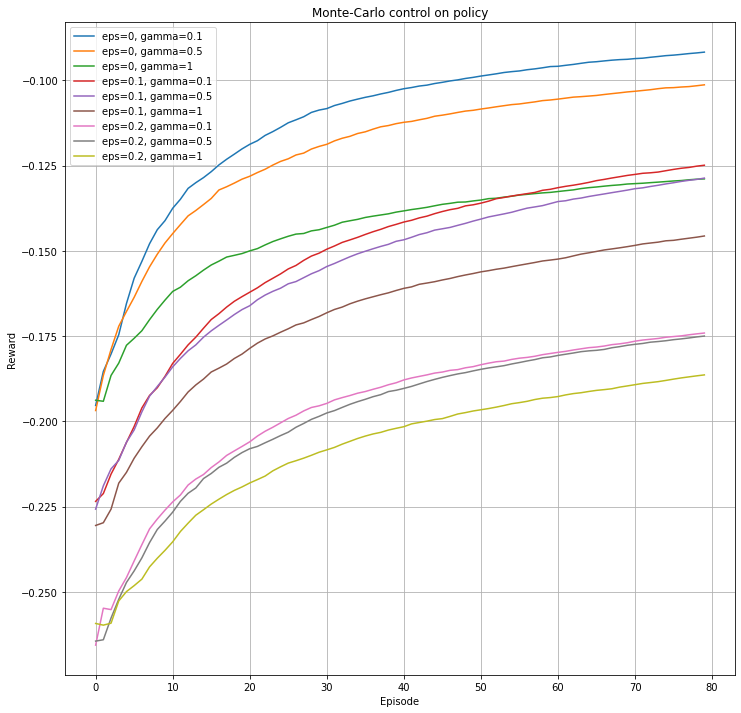

In [ ]:
plot_mean_rewards(
    env,
    MC_control_on_policy,
    'Monte-Carlo control on policy',
    params_for_mc,
    total_episodes=4_000_000
)

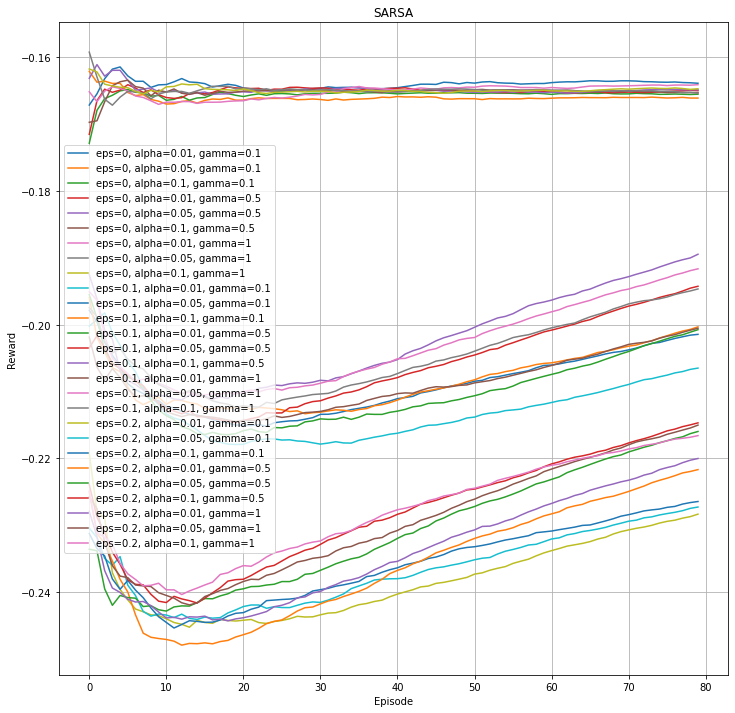

In [ ]:
plot_mean_rewards(
    env,
    SARSA,
    'SARSA',
    params_for_q_learning_n_sarsa,
    total_episodes=4_000_000
)

Чувствуется, что если чуть дольше пообучать Monte-Carlo, то можно практически добиться успеха и играть в казино оставаясь +- на нуле

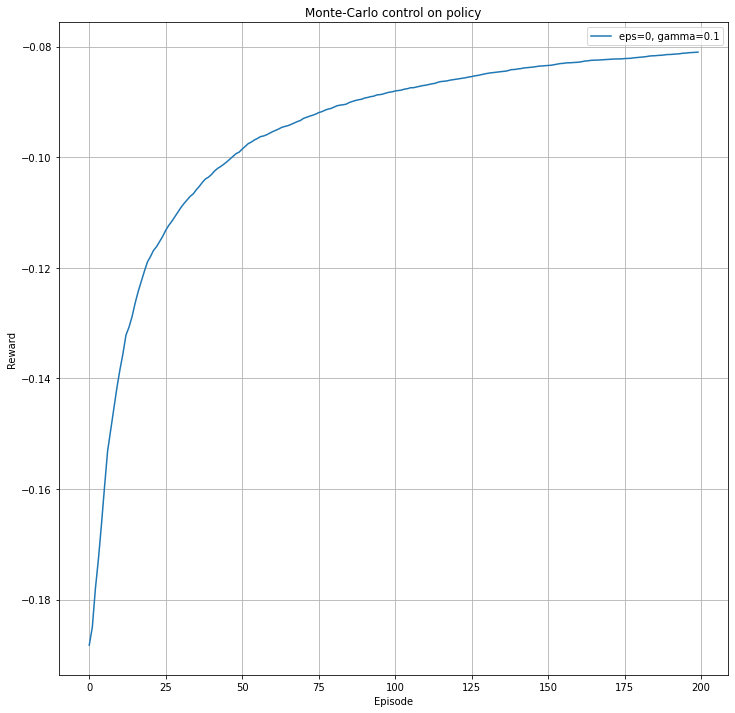

In [ ]:
params_for_mc = [
    {'eps': eps, 'gamma': gamma}
    for (eps, gamma) in itertools.product(
        (0,),
        (0.1,)
    )]

plot_mean_rewards(
    env,
    MC_control_on_policy,
    'Monte-Carlo control on policy',
    params_for_mc,
    total_episodes=10_000_000
)